# 第3章 数据预处理与可视化 部分代码示例

该ipynb文件展示了数据处理过程中的代码示例，包括：“异常值检测”、“填补数据缺失”、“数据不一致检测”、“数据降维”等；还展示了部分数据可视化绘图代码。   
代码中涉及的数据主要来自kaggle竞赛中房价预测数据集：[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)  
运行代码前请将数据集文件和该ipynb文件放在同一目录下

### 数据也可以通过运行下面的代码下载


In [ ]:
import requests
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv'
r = requests.get(DATA_URL, stream=True, verify=True)
with open("./kaggle_house_pred_train.csv", 'wb') as f:
    f.write(r.content)
    
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv'
r = requests.get(DATA_URL, stream=True, verify=True)
with open("./kaggle_house_pred_test.csv", 'wb') as f:
    f.write(r.content)

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
path = "./kaggle_house_pred_train.csv"
df = pd.read_csv(path)
df_data = df.loc[:, df.dtypes != 'object'].iloc[:, 1:] # 筛选df中的数值数据 --该数据为kaggle房价预测数据部分，举例示用，不代表适合下面所有方法
df_data_nona = df_data.dropna()

In [32]:
# 异常值检测 标准差方法（Z-score方法）
df_Z = ((df_data - df_data.mean()) / df_data.std()).abs()
df_Z[df_Z > 3].stack().index

MultiIndex([(   1,  'BsmtHalfBath'),
            (   3, 'EnclosedPorch'),
            (   5,     '3SsnPorch'),
            (   5,       'MiscVal'),
            (   8,  'KitchenAbvGr'),
            (   9,    'MSSubClass'),
            (   9,  'KitchenAbvGr'),
            (  17,  'KitchenAbvGr'),
            (  26,  'BsmtHalfBath'),
            (  28,   'OpenPorchSF'),
            ...
            (1435,   'OverallCond'),
            (1437,     '3SsnPorch'),
            (1439, 'EnclosedPorch'),
            (1440,  'LowQualFinSF'),
            (1445,    'BsmtFinSF2'),
            (1445, 'EnclosedPorch'),
            (1457,   'OverallCond'),
            (1457,       'MiscVal'),
            (1458,    'BsmtFinSF2'),
            (1459,    'WoodDeckSF')],
           length=506)

In [22]:
# 异常值检测 IQR（四分位距）方法
array = np.array([86,65,90,-50,82,91,300,40])
array.sort()
# 计算第一四分位数Q1
Q1 = np.percentile(array, 25)
# 计算第三四分位数Q3
Q3 = np.percentile(array, 75)
IQR = Q3 - Q1
err_ls = [num for num in array if num > Q3+1.5*IQR or num < Q1-1.5*IQR] 
print("第一四分位数 Q1:", Q1)
print("第三四分位数 Q3:", Q3)
print("IQR:", IQR)
print("异常值：", err_ls)

第一四分位数 Q1: 58.75
第三四分位数 Q3: 90.25
IQR: 31.5
异常值： [-50, 300]


In [25]:
# 异常值检测 Grubbs'检验（格拉布斯检验

# 定义Grubbs'检验函数
def grubbs_test(data, alpha=0.05):
    n = len(data)
    if n <= 2:
        return "Grubbs' test is not applicable for samples with less than 3 observations."
    # 计算平均值和标准差
    mean_val = np.mean(data)
    std_dev = np.std(data)
    # 计算绝对偏差
    abs_devs = np.abs(data - mean_val)
    # 找出最大绝对偏差及其索引
    max_abs_dev = np.max(abs_devs)
    max_index = np.argmax(abs_devs)
    # 计算Grubbs'统计量G
    G = (max_abs_dev / std_dev) * (n - 1) ** 0.5  
    # 获取临界值
    critical_value = stats.t.ppf(1 - alpha, n - 2)
    # 判断是否拒绝原假设
    if G > critical_value:
        rejected = True
        print(f"Grubbs' test rejects the null hypothesis. The data point {data[max_index]} is considered an outlier.")
    else:
        rejected = False
        print("Grubbs' test fails to reject the null hypothesis. No outliers detected.")
    return rejected, G, critical_value
# 示例数据 --该数据为举例示用，不代表适合该方法
data = [86,65,90,-50,82,91,300,40]
# 执行Grubbs'检验
outlier, G_value, critical_value = grubbs_test(data)
# 打印结果
print(f"Grubbs' Test Statistics: G = {G_value}, Critical Value = {critical_value}")

Grubbs' test rejects the null hypothesis. The data point 300 is considered an outlier.
Grubbs' Test Statistics: G = 6.134811514032643, Critical Value = 1.9431802803927816


In [49]:
# 基于KNN的异常值检测算法
from sklearn.neighbors import NearestNeighbors
def knn_outlier_detection(data, k=5, threshold=0.5):
    """
    基于KNN的异常值检测算法。
    参数:
    data -- 二维数组，每行代表一个样本，每列代表一个特征
    k -- 近邻的数量
    threshold -- 阈值，用于判断异常值
    返回:
    outliers -- 一个布尔数组，表示每个点是否是异常值
    """
    # 使用KNN找到每个点的k个最近邻居
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    # 计算每个点的邻居中同类点的比例
    same_class = np.sum(indices == np.arange(len(data)), axis=1) / k
    # 判断哪些点是异常值
    outliers = same_class < threshold
    return outliers

# 示例数据 --该数据为kaggle房价预测数据部分，举例示用，不代表适合该方法
X = df_data_nona.iloc[:, :2]
# 执行KNN异常值检测
outliers = knn_outlier_detection(X, k=3, threshold=0.5)
# 打印结果
print("Outliers:", outliers)

Outliers: [False False False ...  True False False]


In [50]:
# 异常值检测 局部离群因子（LOF）算法
from sklearn.neighbors import LocalOutlierFactor

# 示例数据 --该数据为kaggle房价预测数据部分，举例示用，不代表适合该方法
X = df_data_nona.iloc[:, :2]
# 创建LOF模型
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
# 计算局部离群因子
lof_scores = lof.fit_predict(X)
# 通常，负的LOF分数表示异常值
outliers = np.where(lof_scores < 0)[0]
print("Detected outliers:", outliers)

LOF scores: [1 1 1 ... 1 1 1]
Detected outliers: [   4    8   12   37   46   47   50   55   66   74   79   89   96  100
  135  148  153  161  181  191  203  204  205  209  228  232  240  250
  252  253  259  260  281  294  295  313  319  330  338  339  349  375
  404  424  428  435  485  494  515  518  531  560  569  578  579  592
  602  603  615  621  622  634  641  651  662  664  669  685  686  690
  716  730  739  752  759  760  819  822  865  870  902  907  938  963
  980 1012 1057 1070 1077 1083]


In [52]:
# 均值填补数据缺失
mean_values  = df_data.mean()
df_data_fill = df_data.fillna(mean_values)

In [55]:
# 中位数填补数据缺失
median_values  = df_data.median()
df_data_fill = df_data.fillna(median_values)

In [56]:
# 众数填补数据缺失
mode_values  = df_data.mode().iloc[0]
df_data_fill = df_data.fillna(mode_values)

In [54]:
# 前向填充填补数据缺失
df_data_fill = df_data.fillna(method='ffill')

In [57]:
# 后向填充填补数据缺失
df_data_fill = df_data.fillna(method='bfill')

In [ ]:
# 线性插值
df_data_fill = df_data.interpolate(method='linear')

In [60]:
# 拉格朗日插值
from scipy.interpolate import lagrange
x = df['YearBuilt'].dropna().values
y = df['YearBuilt'].values
# 计算插值
f = lagrange(x, y)
df['column'] = f(df.index)
# 如果有需要，可以将插值结果限制在已知数据的范围内
df['column'] = df['column'].clip(min(y), max(y))

d:\anaconda\Lib\site-packages\numpy\lib\polynomial.py:1373: RuntimeWarning: divide by zero encountered in divide
  return poly1d(self.coeffs/other)
d:\anaconda\Lib\site-packages\numpy\lib\polynomial.py:843: RuntimeWarning: invalid value encountered in add
  val = a1 + a2


In [61]:
# 最近邻插补
from sklearn.impute import KNNImputer

# 创建KNN插补器，n_neighbors是最近邻的数量
imputer = KNNImputer(n_neighbors=1)

# 只对某一列进行插补
df['YearBuilt'] = imputer.fit_transform(df[['YearBuilt']])

In [66]:
# 最小-最大规范化
arr = np.array([86,65,90,58,82,91,200,40,20,96,80,50,80,92])
max_new = 1
min_new = 0
arr = (arr - arr.min()) / (arr.max() - arr.min()) * (max_new - min_new) + min_new
arr


array([0.36666667, 0.25      , 0.38888889, 0.21111111, 0.34444444,
       0.39444444, 1.        , 0.11111111, 0.        , 0.42222222,
       0.33333333, 0.16666667, 0.33333333, 0.4       ])

In [68]:
# Z-score规范化
arr = np.array([86,65,90,58,82,91,200,40,20,96,80,50,80,92])
arr = (arr - arr.mean()) / arr.std()
arr

array([ 0.1337563 , -0.39765386,  0.23497728, -0.57479058,  0.03253532,
        0.26028253,  3.01855431, -1.03028501, -1.53638992,  0.38680876,
       -0.01807518, -0.77723255, -0.01807518,  0.28558777])

In [70]:
# 小数定标规范化
arr = np.array([86,65,90,58,82,91,200,40,20,96,80,50,80,92])
k = 1
arr = arr / (10 ^ k)
arr

array([ 7.81818182,  5.90909091,  8.18181818,  5.27272727,  7.45454545,
        8.27272727, 18.18181818,  3.63636364,  1.81818182,  8.72727273,
        7.27272727,  4.54545455,  7.27272727,  8.36363636])

In [52]:
# 主成分分析PCA降维

'''
from sklearn.decomposition import PCA

# 初始化PCA对象，n_components是你想要降到的维度数
pca = PCA(n_components=k)
# 拟合数据并进行转换
data_reduced = pca.fit_transform(df_data_nona)
'''
from scipy.linalg import eig, svd
from sklearn.decomposition import PCA

n = 10
X = df_data_nona.loc[:n, ['MSSubClass','LotFrontage','WoodDeckSF','OpenPorchSF']]

# 首先，我们需要将数据中心化
X_centered = (X - X.mean()).to_numpy()

cov_matrix = (X_centered.T @ X_centered) / n
print("\n协方差矩阵:")
print(cov_matrix)
# 获取特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = sorted(eigenvalues, reverse=True)
eigenvectors =  eigenvectors[:, sorted_indices]
# 计算累计贡献率
cumulative_explained_variance = np.cumsum(eigenvalues)
cumulative_contributions = cumulative_explained_variance / cumulative_explained_variance[-1]

# 打印结果
print("特征值 (贡献率):")
for i, eigenvalue in enumerate(eigenvalues):
    print(f"第 {i+1} 个特征值: {eigenvalue:.4f} (贡献率: {eigenvalue / np.sum(eigenvalues):.2%})")

print("\n特征向量:")
print(eigenvectors.round(2))

print("\n累计贡献率:")
for i, contribution in enumerate(cumulative_contributions):
    print(f"前 {i+1} 个主成分的累计贡献率: {contribution:.2%}")


协方差矩阵:
[[ 2200.    -326.   -2342.    -171.  ]
 [ -326.     142.16   688.3    146.76]
 [-2342.     688.3  12383.05   447.55]
 [ -171.     146.76   447.55   813.41]]
特征值 (贡献率):
第 1 个特征值: 12958.0013 (贡献率: 83.39%)
第 2 个特征值: 1712.9373 (贡献率: 11.02%)
第 3 个特征值: 803.6652 (贡献率: 5.17%)
第 4 个特征值: 64.0162 (贡献率: 0.41%)

特征向量:
[[-0.21  0.96  0.11  0.11]
 [ 0.06 -0.11  0.14  0.98]
 [ 0.97  0.22 -0.02 -0.03]
 [ 0.04 -0.09  0.98 -0.15]]

累计贡献率:
前 1 个主成分的累计贡献率: 83.39%
前 2 个主成分的累计贡献率: 94.42%
前 3 个主成分的累计贡献率: 99.59%
前 4 个主成分的累计贡献率: 100.00%


In [29]:
eigenvectors[0]

array([-9.99301768e-01,  3.73624332e-02, -1.51176659e-04,  3.88668256e-05])

In [76]:
# 线性判别分析降维
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# 创建一个模拟的分类数据集
X, y = make_classification(n_samples=100, n_features=20, n_informative=3, n_classes=3, random_state=42)

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建LDA模型
lda = LDA(n_components=2)  # 假设我们想要降到2维

# 拟合模型
lda.fit(X_train_scaled, y_train)

# 转换数据
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

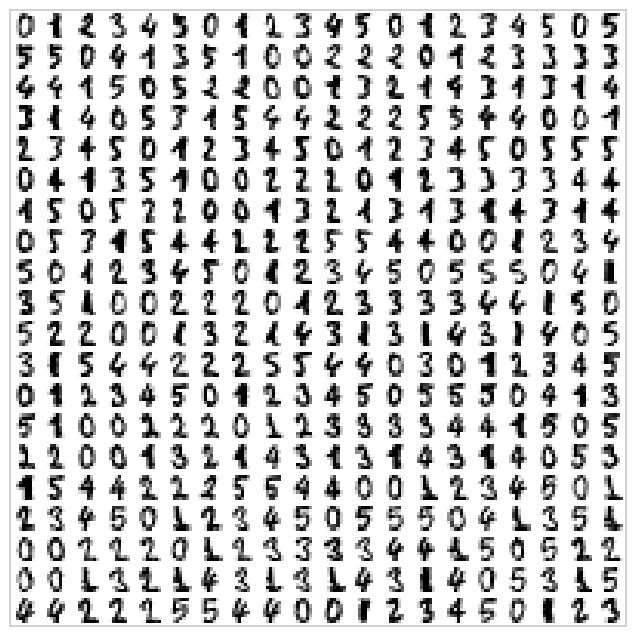

Org data dimension is 64. Embedded data dimension is 2


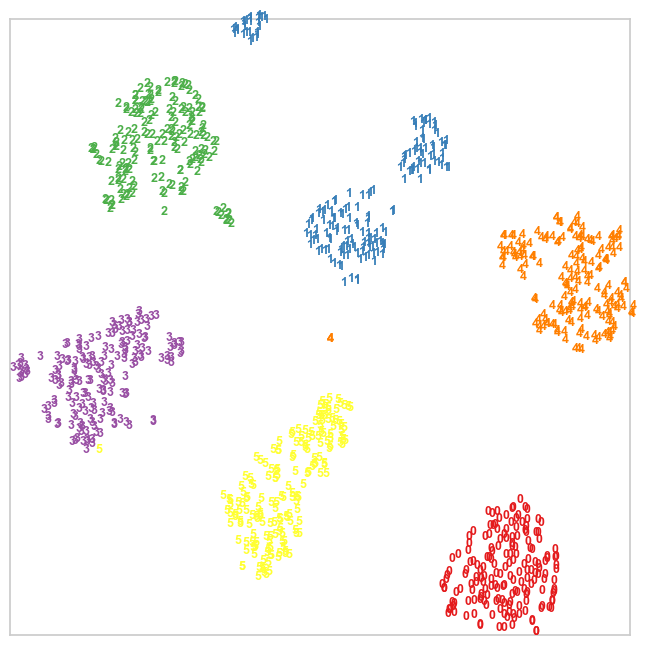

In [4]:
# t分布邻域嵌入降维
from sklearn import manifold, datasets
 
digits = datasets.load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
 
'''显示原始数据'''
n = 20  # 每行20个数字，每列20个数字
img = np.zeros((10 * n, 10 * n))
for i in range(n):
    ix = 10 * i + 1
    for j in range(n):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n + j].reshape((8, 8))
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
 
print("Org data dimension is {}. Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))
 
'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

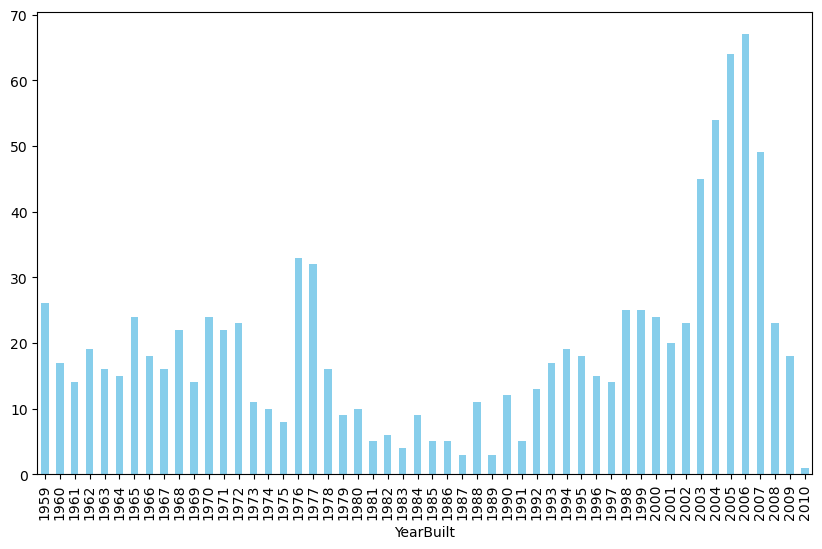

In [41]:
# 条形图
df_data = df['YearBuilt'].value_counts().sort_index().iloc[60:]
df_data.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.show()

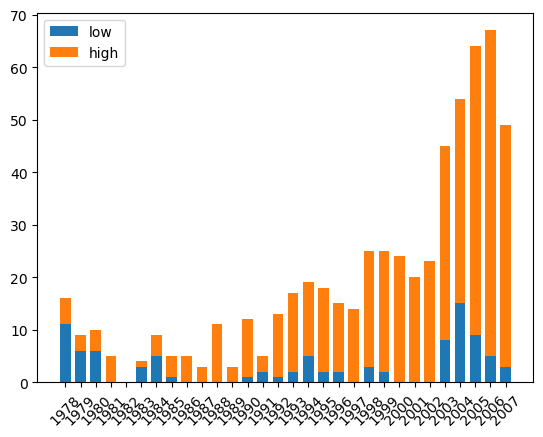

In [10]:
# 堆积条形图
fig=plt.figure()
ax=fig.add_subplot()   

labels = np.arange(1978,2008)
plt.xticks(labels)
high = [ 5,  3,  4,  5,0,  1,  4,  4,  5,  3, 11,  3, 11,  3, 12, 15, 14, 16,13, 14, 22, 23, 24, 20, 23, 37, 39, 55, 62, 46]
low = [11,  6,  6, 0,0, 3,  5,  1,0,0,0,0,  1,  2,  1,  2,  5,  2,  2,0,  3,  2,0,0,0,  8, 15,  9,  5,  3]
width = 0.7 # 设置条形图一个长条的宽度
p1 = ax.bar(labels, low, width) 
p2 = ax.bar(labels, high, width, bottom=low)  
ax.legend((p1[0], p2[0]), ('low', 'high'))
plt.xticks(rotation=45) 
plt.show()
#将画布保存
fig.savefig('qipao.svg', dpi = 400)


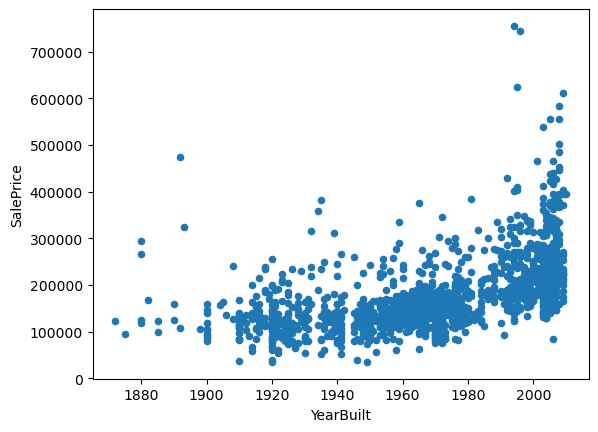

In [33]:
# 散点图
df.plot(kind='scatter', x='YearBuilt', y='SalePrice')
plt.show()

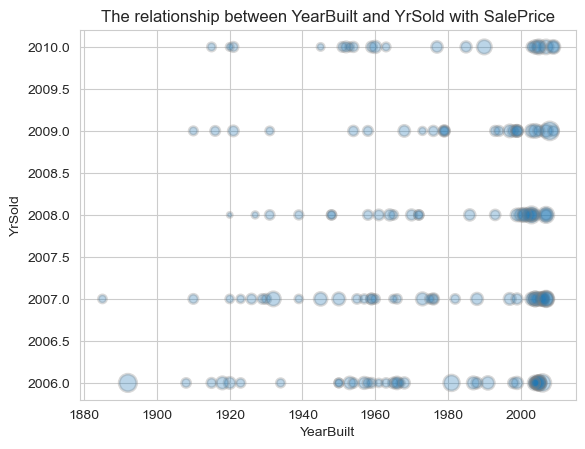

In [75]:
# 气泡图
df_plot = df_data_nona.loc[:200, ['YearBuilt','YrSold', 'SalePrice']]
price = df_plot['SalePrice']
fig = plt.scatter(df_plot['YearBuilt'], df_plot['YrSold'], s=price/3000, alpha=0.3, edgecolors="grey",
            linewidth=2)
plt.xlabel('YearBuilt')  # 横坐标轴标题
plt.ylabel('YrSold')  # 纵坐标轴标题
plt.title('The relationship between YearBuilt and YrSold with SalePrice')
plt.show()
#将画布保存
figure = fig.get_figure()
figure.savefig('qipao.svg', dpi = 400)


d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


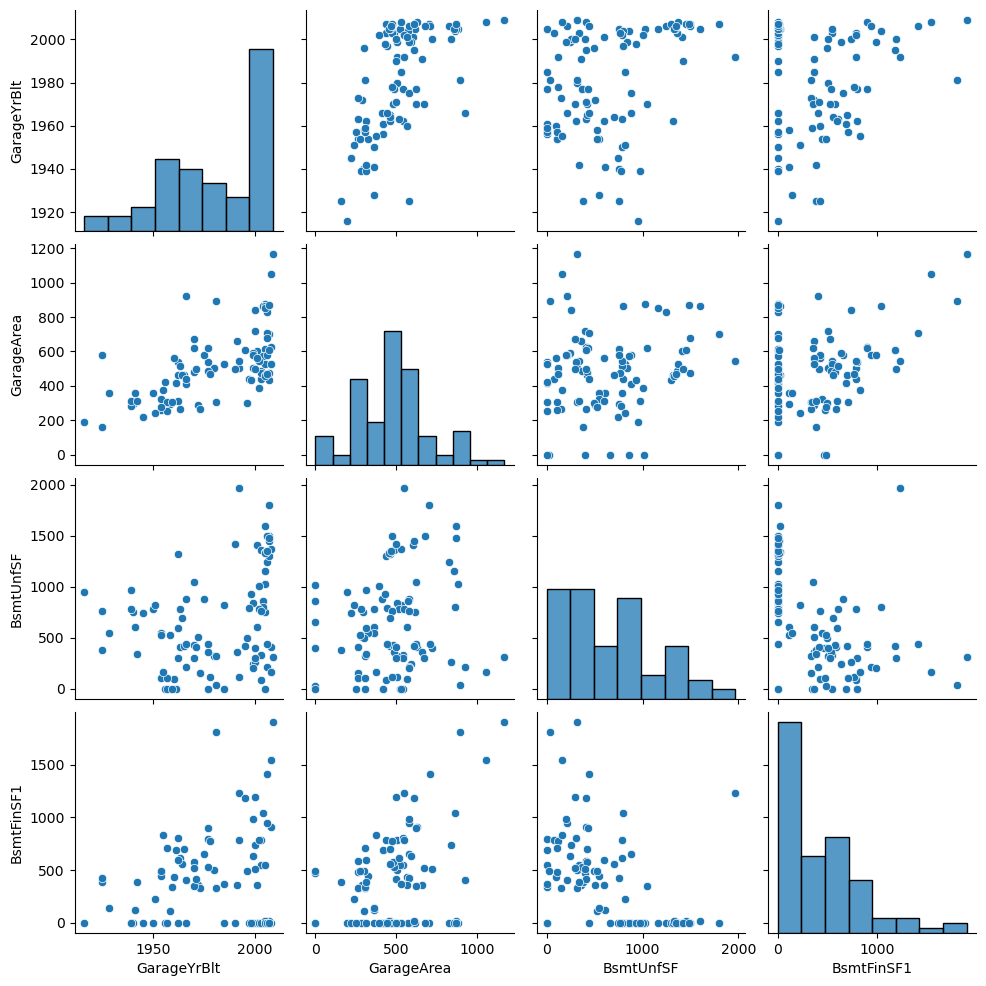

In [9]:
# 散点图矩阵
fig = sns.pairplot(df_data.sample(n=100)[['GarageYrBlt','GarageArea','BsmtUnfSF','BsmtFinSF1']])
plt.show()

#将画布保存

fig.savefig('pairplot.svg', dpi = 400)

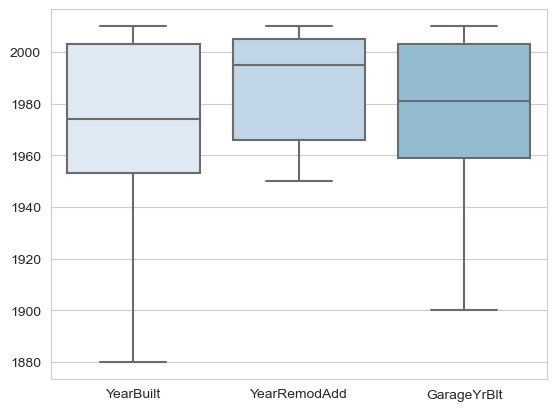

In [36]:
# 箱线图
data = df_data_nona.loc[:, ['YearBuilt','YearRemodAdd', 'GarageYrBlt']].to_numpy()

fig = sns.boxplot(data=data,palette=sns.color_palette('Blues'))
fig.set_xticklabels(['YearBuilt','YearRemodAdd', 'GarageYrBlt'])
plt.show()

#将画布保存
figure = fig.get_figure()
figure.savefig('xiangxian.svg', dpi = 400)

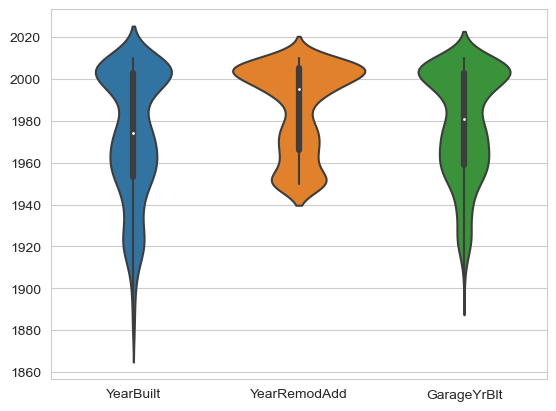

In [38]:
# 小提琴图
data = df_data_nona.loc[:, ['YearBuilt','YearRemodAdd', 'GarageYrBlt']].to_numpy()

fig = sns.violinplot(data=data,split=True)
fig.set_xticklabels(['YearBuilt','YearRemodAdd', 'GarageYrBlt'])
plt.show()

#将画布保存
figure = fig.get_figure()
figure.savefig('violin.svg', dpi = 400)

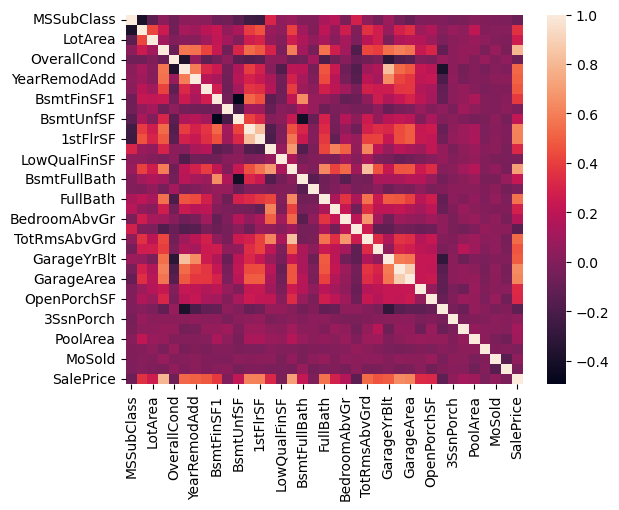

In [10]:
# 热力图
fig = sns.heatmap(df_data.corr())
plt.show()

#将画布保存
figure = fig.get_figure()
figure.savefig('reli.svg', dpi = 400)

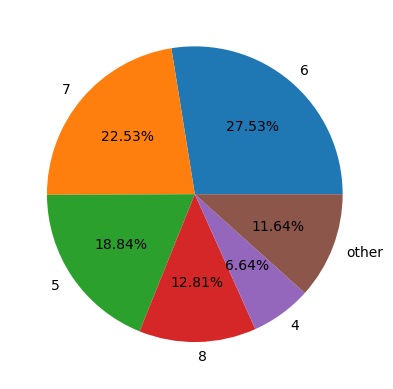

In [22]:
# 饼图
pie_num = 6 # 定义饼块数量
TotRmsAbvGrd_index = list(df['TotRmsAbvGrd'].value_counts().index)[:pie_num]
TotRmsAbvGrd_index[-1] = 'other'
TotRmsAbvGrd_count = np.array(df['TotRmsAbvGrd'].value_counts())
TotRmsAbvGrd_count = np.append(TotRmsAbvGrd_count[:pie_num-1], TotRmsAbvGrd_count[pie_num-1:].sum())
plt.pie(TotRmsAbvGrd_count, labels=TotRmsAbvGrd_index, autopct='%.2f%%') 
plt.show() 

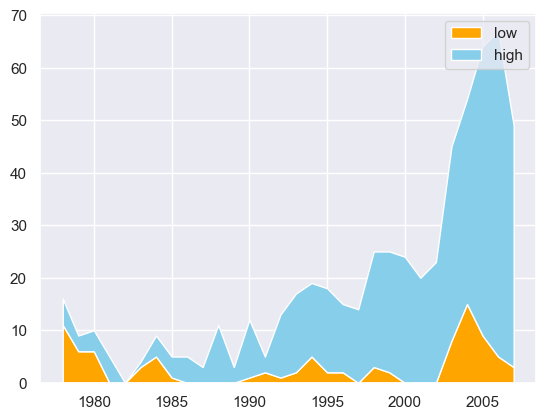

In [18]:
# 堆积条形图
fig=plt.figure()
sns.set_theme()

data = {'year': np.arange(1978,2008),

        'high': [5,3,4,5,0,1,4,4,5,3,11,3,11,3,12,15,14,16,13,14,22,23,24,20,23,37,39,55,62,46],

        'low': [11,6,6,0,0,3,5,1,0,0,0,0,1,2,1,2,5,2,2,0,3,2,0,0,0,8,15,9,5,3]}

df = pd.DataFrame(data)

plt.stackplot(df.year, df.low, df.high,labels=['low', 'high'],colors=['orange', 'skyblue'])
plt.legend(['low', 'high'])
plt.show()
#将画布保存
figure = fig.get_figure()
figure.savefig('area.svg', dpi = 400)

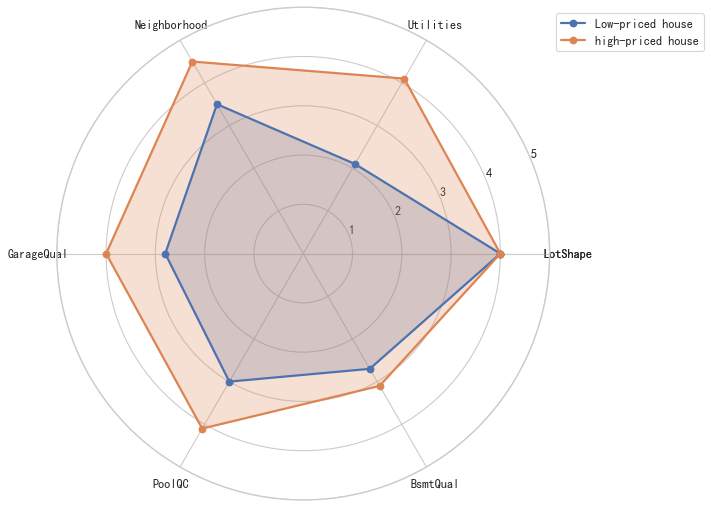

In [48]:
# 雷达图
values = [4,2.1,3.5,2.8,3,2.7]
values2 = [4,4.1,4.5,4,4.1,3.1]
feature = ['LotShape','Utilities','Neighborhood','GarageQual','PoolQC','BsmtQual']
N = len(values)
# 设置雷达图的角度，用于平分切开一个圆面
angles=np.linspace(0, 2*np.pi, N, endpoint=False)

# 将雷达图中的折线图封闭
values=np.concatenate((values,[values[0]]))
values2=np.concatenate((values2,[values2[0]]))
angles=np.concatenate((angles,[angles[0]]))
feature=np.concatenate((feature,[feature[0]]))
# 绘图
fig=plt.figure(figsize=(20,8),dpi=80)
ax = fig.add_subplot(111, polar=True)

# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2, label = 'Low-priced house')

# 填充颜色
ax.fill(angles, values, alpha=0.25)

# 绘制第二条折线图
ax.plot(angles, values2, 'o-', linewidth=2, label = 'high-priced house')
ax.fill(angles, values2, alpha=0.25)

# 添加每个特征的标签
ax.set_thetagrids(angles*180/np.pi, feature)

# 设置雷达图的范围
ax.set_ylim(0,5)

# 添加网格线
ax.grid(True)

# 设置图例
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
# 显示图形
plt.show()

figure = fig.get_figure()
figure.savefig('Radar.svg', dpi = 400)


In [76]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True) 

df_data.loc[df_data['SalePrice'] > df_data.SalePrice.mean(), 'type'] = 2
df_data.loc[df_data['SalePrice'] <= df_data.SalePrice.mean(), 'type'] = 1
df_year = df_data.sample(50)[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','type']].dropna()

py.offline.iplot({
    "data": [go.Parcoords(
        line = dict(color = df_year['type'],
                   colorscale = [[0,'#D7C16B'],[0.5,'#23D8C3'],]),
        dimensions = list([
            dict(range = [1860,2017],
                label = 'YearBuilt', values = df_year['YearBuilt']),
            dict(range = [1940,2018],
                label = 'YearRemodAdd', values = df_year['YearRemodAdd']),
            dict(range = [1896,2017],
                label = 'GarageYrBlt', values = df_year['GarageYrBlt']),
            dict(range = [2005,2015],
                label = 'YrSold', values = df_year['YrSold'])
        ])
    )],
    "layout": go.Layout(title='houses parallel coordinates plot')
})
plt.show()